# Nifty 50 Partial Replication

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("always", category=ConvergenceWarning)
import seaborn as sns

import xgboost as xgb
from sklearn.feature_selection import SelectFromModel,mutual_info_regression

In [2]:
def tracking_error(y_true, y_pred):
    # Convert y_true and y_pred to pandas Series for easy handling of pct_change()
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    
    # Calculate percentage change for true values and predictions
    # pct_change_true = y_true.pct_change() * 100
    # pct_change_pred = y_pred.pct_change() * 100
    
    # Calculate the difference between the percentage changes
    diff_pct_change = y_true - y_pred    
    
    # Return the standard deviation of the differences (tracking error)
    return np.std(diff_pct_change.dropna())  # dropna() to avoid NaN values in pct_change

## Data

In [3]:
# directory_path = '/kaggle/input/stock-market-data-nifty-50-stocks-1-min-data'
# pattern = os.path.join(directory_path, "*.csv")  # Change "*.csv" to match other patterns if needed

# Get the list of files that match the pattern
# file_list = glob.glob(pattern)

In [4]:
def fetch_data(cols):
    df_list = []
    for file in tqdm(file_list):
        stock_name = os.path.basename(file).split("_")[0]
        file_df = pd.read_csv(file, index_col=0)
        file_df = file_df[[cols]]
        file_df.columns = pd.MultiIndex.from_product([[stock_name], file_df.columns])
        df_list.append(file_df)
    return pd.concat(df_list, axis=1)

In [5]:
# df = fetch_data('close')
# df.to_csv('/kaggle/input/nifty_50_closing.csv')

In [6]:
df = pd.read_csv('/kaggle/input/nifty-50-closing-data/nifty_50_closing.csv', index_col=0, header=[0, 1])
df = df.xs('close', level=1, axis=1)
df.index = pd.to_datetime(df.index)

nan_rows = df.isna().any(axis=1)

# Get the number of rows with NaN values
num_nan_rows = nan_rows.sum()

print(f"Number of rows with NaN values: {num_nan_rows}")

Number of rows with NaN values: 639555


In [7]:
nifty_100_closing = pd.read_csv('/kaggle/input/nifty-50-minute-data/NIFTY 100_minute.csv', index_col=0)[['close']]
nifty_100_closing.index = pd.to_datetime(nifty_100_closing.index)
nifty_100_closing.rename(columns={'close': 'NIFTY_100'}, inplace=True)

In [8]:
print(f"Index type for df1: {type(df.index)}")
print(f"Index type for df2: {type(nifty_100_closing.index)}")

Index type for df1: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type for df2: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [9]:
# df.interpolate(method='linear', inplace=True)
# To fill the first row NaN with the value from the next minute
threshold = 0.10

# Drop columns with more than the threshold percentage of missing values
df = df.dropna(thresh=int((1-threshold) * len(df)), axis=1)

# Get the number of rows with any 0.0 values

df.fillna(0, inplace=True)
df.index = df.index.tz_localize(None)

zero_rows = (df == 0.0).any(axis=1)


num_zero_rows = zero_rows.sum()

print(f"Number of rows with 0.0 values: {num_zero_rows}")
print(f"Total rows {len(df)}")
df.head(3)

Number of rows with 0.0 values: 37286
Total rows 677188


,APOLLOHOSP,BOSCHLTD,INDUSTOWER,BERGEPAINT,MARICO,SBIN,SUNPHARMA,COALINDIA,WIPRO,BAJAJ-AUTO,...,BIOCON,DABUR,SAIL,BRITANNIA,ADANIPORTS,ONGC,EICHERMOT,TECHM,JINDALSTEL,HEROMOTOCO
date,,,,,,,,,,,,,,,,,,,,,
2018-08-06 10:47:00,974.3,19187.45,290.0,316.85,357.95,306.70,579.65,282.05,207.93,2695.00,...,287.40,435.30,79.35,3194.92,400.70,167.75,2711.3,670.45,207.65,3259.0
2018-08-06 10:48:00,973.7,19187.45,290.0,316.50,357.55,306.70,579.30,282.05,207.93,2695.00,...,287.75,435.15,79.30,3193.02,400.55,167.55,2710.6,670.55,207.80,3260.6
2018-08-06 10:49:00,973.7,19187.45,290.0,316.85,357.20,306.75,579.45,282.00,207.97,2697.95,...,287.95,435.70,79.30,3192.50,400.30,167.55,2709.8,670.65,207.55,3259.5


In [10]:
len(df.columns)

88

In [11]:
df_total = df.join(nifty_100_closing, how='left')

In [12]:
df_total.dropna(inplace=True)

In [13]:
# Calculate the percentage change
X_pct_change = df_total.pct_change()

# Define the threshold for large changes (e.g., 100% change)
threshold = 1.0  # 1.0 corresponds to 100% when working with pct_change()

# Find rows with any column having a percentage change greater than the threshold
large_change_rows = X_pct_change[(X_pct_change.abs() > threshold).any(axis=1)]

# Get the number of rows where there are large percentage changes
num_large_changes = large_change_rows.shape[0]

print(f"Number of rows with large changes (>{threshold * 100}%): {num_large_changes}")

Number of rows with large changes (>100.0%): 14551


In [14]:
print(len(df_total))

666554


# Models

## Combined Approach
In this section, we will utilize a combined approach to limit the number of features (stocks) and train our models.

1. Feature Selection (using Lasso w/ high alpha, Mutual Info, ANOVA, RFE)
2. Define threshold to drop features
3. Train model on reduced feature space (Hyperparameter tuned)
4. Get tracking error
5. Save pair (number of stocks, tracking error) for plotting

### Lasso - Lasso

We will utilize a Lasso model with a high alpha value to perform feature selection, this will drop the coefficients for less important features to 0. After that we retrain a Lasso model with hyperparameter tuning.

In [15]:
from sklearn.preprocessing import StandardScaler

def Lasso_Lasso(alpha, X, y):    
    tscv = TimeSeriesSplit(n_splits=5)
    stocks = []
    num_stocks = []
    fold_scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)
        
        # Feature selection with alpha from list
        lasso_fs = Lasso(alpha=alpha, max_iter=200)
        lasso_fs.fit(X_scaled, y_train_cv)

        #for feature, coef in zip(X_train_cv.columns, lasso_fs.coef_):
        #    print(f"{feature}: {coef}")

        selector = SelectFromModel(lasso_fs, threshold=10e-10, max_features=None)  # Adjust threshold as needed
        X_selected_train = selector.transform(X_scaled)
        X_selected_test = selector.transform(X_scaled)

        selected_features = np.where(selector.get_support())[0] 
        print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))
        stocks.append(selected_features)

        best_alpha = None
        best_score = float('inf')  # Assuming lower is better for your metric
        for alph in [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025]:
            lasso = Lasso(alpha=alph, max_iter=15000)
            lasso.fit(X_selected_train, y_train_cv)
    
            y_pred = lasso.predict(X_selected_test)
            fold_score = tracking_error(y_test_cv.values, y_pred)  # Replace with your metric
            # print(f"Alpha: {alpha}, Fold Score: {fold_score}")
    
            if fold_score < best_score:
                best_score = fold_score
                best_alpha = alpha
    
        print(f"Best Alpha for this fold: {best_alpha}, Best Fold Score: {best_score}")
        fold_scores.append(best_score)
        
    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)
    
    # Print the tracking error for this alpha
    print(f"Alpha: {alpha}, Average Tracking Error: {average_score}")
 
    return stocks, average_selected_features, average_score

Starting alpha 0.001
Selected 76 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.09939982762298774


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e-01, tolerance: 1.155e-01
  model = cd_fast.enet_coordinate_descent(


Selected 81 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.0672159923115898


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.015e-01, tolerance: 1.462e-01
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.16727972423037465


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.557e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 74 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.06130021200522088


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.174e+00, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 75 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.3685856995504441
Alpha: 0.001, Average Tracking Error: 0.15275629114412342
Starting alpha 0.002
Selected 66 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.09939977740252205
Selected 74 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.06721595624383762
Selected 77 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.16727979506596014


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.950e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 64 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.061299844221711426


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.450e+00, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 64 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.36858509773733455
Alpha: 0.002, Average Tracking Error: 0.15275609413427316
Starting alpha 0.003
Selected 56 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.09939842751809944
Selected 69 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.06721741088141409
Selected 67 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.1672800633546856


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.406e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 57 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.0612593733047479


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.592e+00, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 59 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.3685821248853948
Alpha: 0.003, Average Tracking Error: 0.15274747998886837
Starting alpha 0.004
Selected 44 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.09939047466208052
Selected 60 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.06721625921287078
Selected 60 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.1672743631297189


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 51 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.06124999521220005


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.612e+00, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 49 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.36858042966920485
Alpha: 0.004, Average Tracking Error: 0.152742304377215
Starting alpha 0.005
Selected 37 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.09937465902396109
Selected 53 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.06719608076603815
Selected 53 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.1672823884444782


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.659e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 47 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.06125575370214231


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e+00, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 48 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.3685729398854178
Alpha: 0.005, Average Tracking Error: 0.15273636436440752
Starting alpha 0.006
Selected 30 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.09935931054156509
Selected 48 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.067189509530875
Selected 48 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.16728806846460859


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.403e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 43 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.06118141528443277


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+00, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 41 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.36857219156266074
Alpha: 0.006, Average Tracking Error: 0.15271809907682843
Starting alpha 0.007
Selected 24 stocks
Best Alpha for this fold: 0.007, Best Fold Score: 0.09933331252272157
Selected 41 stocks
Best Alpha for this fold: 0.007, Best Fold Score: 0.06725097436356614
Selected 40 stocks
Best Alpha for this fold: 0.007, Best Fold Score: 0.16727566702911045


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.098e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 40 stocks
Best Alpha for this fold: 0.007, Best Fold Score: 0.061148780236656326


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.008e-01, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 38 stocks
Best Alpha for this fold: 0.007, Best Fold Score: 0.36856116921760795
Alpha: 0.007, Average Tracking Error: 0.15271398067393246
Starting alpha 0.008
Selected 21 stocks
Best Alpha for this fold: 0.008, Best Fold Score: 0.09927815300519323
Selected 36 stocks
Best Alpha for this fold: 0.008, Best Fold Score: 0.06720517116775272
Selected 37 stocks
Best Alpha for this fold: 0.008, Best Fold Score: 0.16728849879846103


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 39 stocks
Best Alpha for this fold: 0.008, Best Fold Score: 0.061124174390589


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.697e-01, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 38 stocks
Best Alpha for this fold: 0.008, Best Fold Score: 0.36856116921760795
Alpha: 0.008, Average Tracking Error: 0.15269143331592078
Starting alpha 0.009
Selected 19 stocks
Best Alpha for this fold: 0.009, Best Fold Score: 0.09916988072515447
Selected 33 stocks
Best Alpha for this fold: 0.009, Best Fold Score: 0.06726402446919895
Selected 32 stocks
Best Alpha for this fold: 0.009, Best Fold Score: 0.16727626214897812


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.168e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 36 stocks
Best Alpha for this fold: 0.009, Best Fold Score: 0.06100538612981016


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.150e-01, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 36 stocks
Best Alpha for this fold: 0.009, Best Fold Score: 0.36854506925518193
Alpha: 0.009, Average Tracking Error: 0.15265212454566474


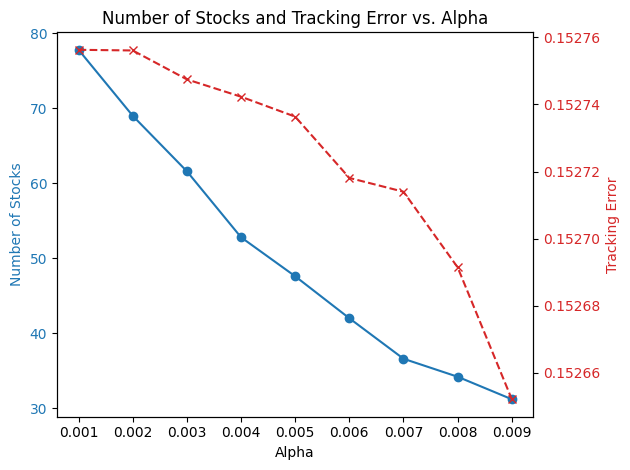

In [16]:
df_total_z = df_total.replace(0, np.nan)  # Convert zeroes back to NaNs
df_total_returns = df_total_z.pct_change().dropna()
df_total_returns = 100*df_total_returns
X = df_total_returns.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total_returns['NIFTY_100']

alphas = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
tracking_errors = []
num_stocks_list = []

for alpha in alphas:
    print(f"Starting alpha {alpha}")
    _, num_stocks, tracking_err = Lasso_Lasso(alpha, X, y)
    num_stocks_list.append(num_stocks)
    tracking_errors.append(tracking_err)

# Plotting the results
fig, ax1 = plt.subplots()

# Plotting number of stocks on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Number of Stocks', color=color)
ax1.plot(alphas, num_stocks_list, color=color, marker='o', label='Number of Stocks')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for tracking error
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Tracking Error', color=color)
ax2.plot(alphas, tracking_errors, color=color, marker='x', linestyle='--', label='Tracking Error')
ax2.tick_params(axis='y', labelcolor=color)

# Adding a title and legend
plt.title('Number of Stocks and Tracking Error vs. Alpha')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Mutual Info - Lasso
Using mutual information between variables, which measures the dependency between them, 0 value being independence. By getting the mutual information between the features (stocks) and the target (NIFTY 100) we can "discard" the variables with lower dependencies. After feature selection, we traing a Lasso model with CV.

In [17]:
def MI_Lasso(percentile, X, y):
    tscv = TimeSeriesSplit(n_splits=3)
    stocks = []
    num_stocks = []
    fold_scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Feature selection with alpha from list
        mi_scores = mutual_info_regression(X_train_cv, y_train_cv)
        mi_scores_series = pd.Series(mi_scores, index=X_train_cv.columns)

        threshold_value = mi_scores_series.quantile(percentile)
        
        selected_features = X_train_cv.columns[mi_scores > threshold_value]

        X_train_selected = X_train_cv[selected_features]
        X_test_selected = X_test_cv[selected_features]
    
        print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))
        stocks.append(selected_features)

        # Train model on the fold with reduced feature space
        lasso = LassoCV(alphas=[0.1, 0.25, 0.5, 1, 2.5, 5], max_iter=10)
        lasso.fit(X_train_selected, y_train_cv)

        y_pred = lasso.predict(X_test_selected)

        # Evaluate the model using the custom metric (e.g., tracking error)
        fold_score = tracking_error(y_test_cv.values, y_pred)
        fold_scores.append(fold_score)
        print(f"Fold Score: {fold_score}")
        
    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)
    
    # Print the tracking error for this alpha
    print(f"Percentile: {percentile}, Average Tracking Error: {average_score}")
 
    return stocks, average_selected_features, average_score

X = df_total.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total['NIFTY_100']

percentiles = [0.1, 0.2, 0.3, 0.4, 0.5]
tracking_errors = []
num_stock_list = []

for percentile in percentiles:
    _, num_stocks, tracking_err = MI_Lasso(percentile, X, y)
    num_stock_list.append(num_stocks)
    tracking_errors.append(tracking_err)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(num_stock_list, tracking_errors, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel("Number of Stocks Selected")
plt.ylabel("Tracking Error")
plt.title("Number of Stocks vs. Tracking Error")
plt.grid(True)
plt.show()